In [39]:
import spacy
from bs4 import BeautifulSoup, SoupStrainer, Tag, NavigableString, ResultSet

In [2]:
from gensim.models import KeyedVectors;

In [3]:
from os import path
import io
import os
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
from sklearn.decomposition import PCA

In [5]:
nlp = spacy.load('en_core_web_md')

In [6]:
#load vectors directly from file
gensim_model = KeyedVectors.load_word2vec_format(path.join(path.expanduser('~'), 
                                                           'Dev', 
                                                           'word2vec', 
                                                           'GoogleNews-Vectors-Negative300.bin'), 
                                                 binary=True)

In [7]:
grocery_gen_wrds=['groceries']

In [8]:
most_sim = gensim_model.most_similar(positive=grocery_gen_wrds, topn=5)
most_sim

[('grocery', 0.7232317328453064),
 ('grocery_store', 0.6671785712242126),
 ('Susan_Warmbier', 0.6374872922897339),
 ('grocery_stores', 0.6255874633789062),
 ('Groceries', 0.6193972229957581)]

In [9]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

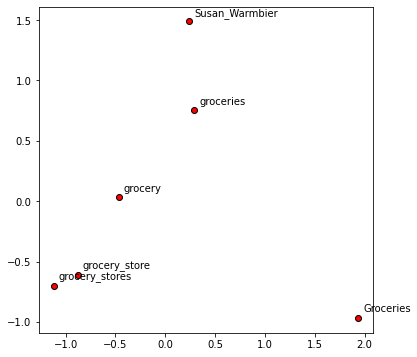

In [10]:
display_pca_scatterplot(gensim_model, grocery_gen_wrds + [w[0]for w in most_sim])

In [37]:
# use the webscraper environment
# to be run the first time you use:
# ! safaridriver --enable
# ! /usr/bin/safaridriver -p 1337</
#Simple assignment

In [11]:
from selenium.webdriver import Safari
from selenium import webdriver
from selenium.webdriver.common.by import By
# driver.find_element(By.XPATH, '//button[text()="Some text"]')
# ID = "id"
# XPATH = "xpath"
# LINK_TEXT = "link text"
# PARTIAL_LINK_TEXT = "partial link text"
# NAME = "name"
# TAG_NAME = "tag name"
# CLASS_NAME = "class name"
# CSS_SELECTOR = "css selector"

In [28]:
driver = Safari()
# implicit wait
# driver.manage().timeouts().implicitlyWait(5)
driver.implicitly_wait(10)

In [32]:
def nth_of_type(elem:Tag):
    count, curr = 0, 0
    for i, e in enumerate(elem.find_parent().find_all(recursive=False), 1):
        if e.name == elem.name:
            count += 1
        if e == elem:
            curr = i
    return '' if count == 1 else ':nth-child({})'.format(curr)

def _getElemSelector(elem:Tag):
    selector = elem.name
    # otherAttrs = set(elem.attrs.keys()).difference('class')
    if elem['class']:
        selector += '.' + '.'.join(elem['class'])

    for otherAtr in elem.attrs.keys():
        if isinstance(elem[otherAtr], list) and otherAtr == 'class':
            pass
        else:
            selector += f'[{otherAtr}="{elem[otherAtr]}"]'
    
    if str(elem.string) and not elem.children:
        selector += f':contains("{elem.text}")'
    
    return selector# + nth_of_type(elem)

def getCssPath(elem, maxTreeSize = 100):
    if elem.attrs.get('id'):
        return '#' + elem.attrs['id']

    rv = [_getElemSelector(elem)]
    _i = 0
    while _i < maxTreeSize:
        _i += 1
        elem = elem.find_parent()
        if not elem or elem.name == '[document]':
            return '>'.join(rv[::-1])
        elif _i >= maxTreeSize:
            return ' ... ' + ' > '.join(rv[::-1])
        elif elem.attrs.get('id'):
            return '#' + elem.attrs['id'] + ' > '.join(rv[::-1])
            
        rv.append(_getElemSelector(elem))

In [55]:
def seleniumTryClickWebEl(wElem):
    clickSuccess = False
    try:
        wElem.click()
        clickSuccess = True
    except Exception as e:
        clickSuccess = False

    return clickSuccess

def selenium_click_css(cssSelector):
    success = False
    webEl = driver.find_element_by_css_selector(cssSelector)
    if webEl:
        if webEl.is_displayed():
            if seleniumTryClickWebEl(webEl):
                driver.execute_script(f'document.querySelector(\'{cssSelector}\').click()')
                success = True
    return success

def selenium_click_webEl(webEl):
    success = False
    if webEl.is_displayed():
        if seleniumTryClickWebEl(webEl):
            if webEl.has_attribute('id'):
                _id = webEl.get_attribute('id')
                driver.execute_script(f'document.getElementById(\'{_id}\').click()')
            else:
                cssSelector = getCssPath(webEl)
                selenium_click_css(cssSelector)
            success = True

    return success

def find_and_agree_cookies(driver:Safari):
    _f = lambda btnText: f"//*[text()='{btnText}']"
    agreebtns = driver.find_elements_by_xpath(_f('I agree'))
    btn_ids= None
    if agreebtns:
        btn_ids = [agreebtn.get_attribute('id') for agreebtn in agreebtns]
    if not btn_ids:
        agreebtns = driver.find_elements_by_xpath(_f('Allow All'))
        if agreebtns:
            btn_ids = [agreebtn.get_attribute('id') for agreebtn in agreebtns]

    for btn_id in btn_ids:
        btn = driver.find_element_by_id(btn_id)
        if btn.is_displayed():
            if seleniumTryClickWebEl(btn):
                # driver.execute_script(f'$(\'#{btn_id}\').click()')
                driver.execute_script(f'document.getElementById(\'{btn_id}\').click()')

In [29]:
driver.get('https://groceries.asda.com')


In [30]:
find_and_agree_cookies(driver)

In [ ]:
# driver.get('https://groceries.asda.com/product/natural-plain-organic/fage-total-fat-free-greek-recipe-natural-yogurt/24771357')

In [41]:
leveledQuerySelects = {
    0:['Groceries'],
    1:['Food', 'Pharmaceuticals', 'Departments', 'Offers', 'Sale'],
    2:[
        'Fruit', 'Veg', 'Vegetables', 'Salad', 'Meat', 'Poultry',
        'Fish', 'Legumes', 'Frozen', 'Organic', 'Free from', 'Cupboard',
        'Vegan', 'Plant', 'Drinks', 'Alcohol', 'Beer', 'Wine', 'Spirits',
        'Home', 'Entertainment', 'Health', 'Beauty', 'Laundry', 'Household',
        'Pet', 'Baby', 'Children'
    ]
}


In [38]:

allHtmlText = driver.page_source # str(driver.find_element_by_xpath("/html/body").get_attribute('outerHTML'))
no_script_tags = SoupStrainer(re.compile(r'^(h[1234])|(input)|(p)|(button)$'))
soup = BeautifulSoup(allHtmlText, 'html.parser', parse_only=no_script_tags)
# print(soup.prettify())

# for s in soup.find_all(re.compile(r'^(h[1234])|(input)|(p)$')):
#     print(s.prettify())
# soup = remove_tags(soup)

In [87]:
# GroceriesBtn = driver.find_element_by_partial_link_text('Groceries')


'<a class="asda-link asda-link--secondary footer__anchor" data-auto-id="footer-link-groceries-app" target="_self" href="/event/mobile-app" data-di-id="di-id-373118c4-bb636f8a">Groceries App</a>'

In [ ]:
# from pprint import pprint

In [ ]:
# # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# allText = soup.get_text()
# # keeping only tagger component needed for lemmatization
# nlp = spacy.load('en_core_web_md')#,  disable=["parser", "ner"])

# doc = nlp(allText)
# most_sim_lwr = [w[0].lower() for w in most_sim]
# lemmaInds = [ind for ind, tkn in enumerate(doc) if [tkn.lemma_.lower() in ss for ss in most_sim_lwr]]
# # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# matchTexts = []
# if lemmaInds:
#     matchTexts = [doc[ind].text for ind in lemmaInds]
# # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# htmlSoupLoc = 0

In [60]:
def matchWords(searchTerms):
    
    tagNavStrArr = None
    for sTerm in searchTerms:
        if tagNavStrArr:
            tagNavStrArr = tagNavStrArr.append(soup.find_all(text=sTerm))
        else:
            tagNavStrArr = soup.find_all(text=sTerm)
    
    
    cssPaths = []
    if tagNavStrArr:
        for tagNavStr in tagNavStrArr:
            tag = tagNavStr.parent
            cssPath = getCssPath(tagNavStr.parent)
            wElem = driver.find_element_by_css_selector(cssPath)
            if wElem.is_displayed():
                cssPaths += [cssPath]

    return cssPaths

def clickPaths(cssPaths):
    anySuccesses = False
    if cssPaths:
        for cssPath in cssPaths:
            succeeded = False
            if driver.find_element_by_css_selector(cssPath):
                succeeded = selenium_click_css(cssPath)
                if not succeeded:
                    print(f'Failed to click element {cssPath}')
            else:
                break
            anySuccesses = (anySuccesses or succeeded)
    else:
        print('Matched no words from: ' + ', '.join(searchTerms))
    return anySuccesses


ind = 2
while ind > -1:
    searchTerms = leveledQuerySelects[ind]
    cssPaths = matchWords(searchTerms)
    anySuccesses = clickPaths(cssPaths)

    if not anySuccesses:
        ind -= 1
        continue


Matched no words from: Fruit, Veg, Vegetables, Salad, Meat, Poultry, Fish, Legumes, Frozen, Organic, Free from, Cupboard, Vegan, Plant, Drinks, Alcohol, Beer, Wine, Spirits, Home, Entertainment, Health, Beauty, Laundry, Household, Pet, Baby, Children
Matched no words from: Food, Pharmaceuticals, Departments, Offers, Sale
Failed to click element button.asda-btn.asda-btn--clear.asda-btn--fluid.navigation-menu__item.navigation-menu__item--active[data-auto-id="buttonMenuItem"][type="button"][aria-expanded="true"][aria-haspopup="menu"]>span.navigation-menu__text


In [51]:
wElem = driver.find_element_by_css_selector(cssPaths[0])




False

Failed to click element button.asda-btn.asda-btn--clear.asda-btn--fluid.navigation-menu__item.navigation-menu__item--active[data-auto-id="buttonMenuItem"][type="button"][aria-expanded="true"][aria-haspopup="menu"]>span.navigation-menu__text


In [ ]:
# for tagNavStr in tagNavStrArr:
#     # print(type(tagNavStr))
#     tag = tagNavStr.parent
#     # form: cssSelector: tagname.className1.classname2#id{'<attribute>'=<value>}
    
#     # actual selector: #root > div.layout > nav > div > div:nth-child(1) > button > span.navigation-menu__text
#     #! Issue is that Soup is Strained and so doesnt have the full tree.
#     cssPath = getCssPath(tagNavStr.parent) # ->  [document] > button > span (which should be otherway round anyhow)
#     print(BeautifulSoup(allHtmlText, 'html.parser').select(cssPath))
#     print(cssPath)
#     # tag = tagNavStr.parent
#     # s = ''
#     # for _ in range(7):
#     #     s = tag.name + ' > ' + s
#     #     tag = tag.parent
#     #     if not tag:
#     #         break
#     # print(s)

#     wElem = driver.find_element_by_css_selector(cssPath)
#     print(wElem)


[<span class="navigation-menu__text">Groceries</span>, <span class="navigation-menu__text">Offers</span>]
button.asda-btn.asda-btn--clear.asda-btn--fluid.navigation-menu__item[data-auto-id="buttonMenuItem"][type="button"][aria-expanded="false"][aria-haspopup="menu"]>span.navigation-menu__text
<selenium.webdriver.remote.webelement.WebElement (session="9790F2CA-9FE1-4CE5-A7D0-6484B39BCDCE", element="node-69DB405D-1517-4382-A605-2DC87DEC07D9")>


In [ ]:
# selenium_click_css(cssPath)

In [110]:

# driver.get('https://groceries.asda.com')

In [103]:
only_header_tags = SoupStrainer(re.compile('h[1234]'))

def minTabsAndLines(pretty_soup_dont_process):
    pretty_soup_dont_process = re.sub(r'\n\t+', ' ', pretty_soup_dont_process)
    # pretty_soup_dont_process = re.sub(r'\t', '-', pretty_soup_dont_process)
    # pretty_soup_dont_process = re.sub(r'\n', '*', pretty_soup_dont_process)
    pretty_soup_dont_process = re.sub(r'\t+', '\t', pretty_soup_dont_process)
    pretty_soup_dont_process = re.sub(r'\n+', '\n', pretty_soup_dont_process)
    return pretty_soup_dont_process

In [100]:
def wordLocator(page, word, webDriver:Safari=None):
    '''
    Page: str (weblink | html) | BeautifulSoup
    '''
    soup = BeautifulSoup()
    if isinstance(page, str):
        if re.match(r'http.*', page):
            print('URL passed')
            URL = page
            if webDriver:
                webDriver.get(URL)
                body_html_el = webDriver.find_element_by_xpath("/html")
                body_html = body_html_el.get_attribute('outerHTML')
                soup = BeautifulSoup(body_html, 'html.parser')
            else:
                print('No Webdriver passed, use Bs4')
                # http://www.xhaus.com/headers -> View your headers in browser
                headers = {"User-agent": 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36 Edg/96.0.1054.43'}
                page = requests.get(URL, headers=headers)
                # print(page.content)
                soup = BeautifulSoup(page.content, 'html.parser')
            page_text = soup.get_text()
        else:
            soup = BeautifulSoup(page, 'html.parser')
            page_text = page
    elif isinstance(page, BeautifulSoup):
        soup = page
        page_text = soup.get_text()
    
    #TODO: Find the xpath of the word within the page
    output = ''
    blacklist = [
        '[document]',
        'noscript',
        
        'head', 
        
        'script',
        # there may be more elements you don't want, such as "style", etc.
    ]
    
    soup.find_all('Groceries')
    soup.find()

    text = soup.find_all(re.compile('h[1234]'), text=True)
    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t)
        elif t.text in word:
            output += '{} '.format(t)
    return output

    

In [101]:
wordLocator('https://groceries.asda.com/product/natural-plain-organic/fage-total-fat-free-greek-recipe-natural-yogurt/24771357',
            'Groceries', webDriver=driver)

URL passed
Fage Total Fat Free Greek Recipe Natural Yogurt - ASDA Groceries




<iframe src="https://www.googletagmanager.com/ns.html?id=GTM-MDCJ74D" height="0" width="0" style="display: none;visibility: hidden"></iframe>Skip to Main ContentSign Inbreadcrumb Chilled Food /breadcrumb Yogurts & Desserts /breadcrumb Yogurts & Fromage Frais /breadcrumb Natural, Plain & Organic Use + and - keys to zoom in and out, arrow keys move the zoomed portion of the imageMouse over image for a closer look.Sponsored products you might like8x115gActivia Mixed Fruit Gut Health Yogurt now £3.00(32.6p/100g)Add4 pintASDA Semi Skimmed Milk now £1.15(50.7p/lt)Add1lCravendale Semi Skimmed Milk now £1.25(£1.25/lt)Add2lCravendale Whole Milk now £1.90(95.0p/lt)Add4x115gLight & Free Fat Free Greek Style Strawberry Yogurts now £2.00(43.5p/100g)Add100gASDA Extra Special Serrano Ham now £2.00was  £2.25(£2.00/100g)RollBackAdd250gViolife Vioblock Salted Vegan Butter Alternative now £2.00(£8.00/kg)Add500gAlpro Vanilla S

'<h3 class="co-product__title pdp-personal-recs__prod-title"><a class="co-product__anchor" data-auto-id="linkProductTitle" data-di-id="di-id-51c8922f-379a8c7" href="/product/1000290068605?origin=/product/natural-plain-organic/fage-total-fat-free-greek-recipe-natural-yogurt/24771357">Activia Mixed Fruit Gut Health Yogurt</a></h3> <h3 class="co-product__title pdp-personal-recs__prod-title"><a class="co-product__anchor" data-auto-id="linkProductTitle" data-di-id="di-id-ba8dc4fa-c0afc28b" href="/product/20504?origin=/product/natural-plain-organic/fage-total-fat-free-greek-recipe-natural-yogurt/24771357">ASDA Semi Skimmed Milk</a></h3> <h3 class="co-product__title pdp-personal-recs__prod-title"><a class="co-product__anchor" data-auto-id="linkProductTitle" data-di-id="di-id-9b3975c5-3ad8d9bb" href="/product/32088739?origin=/product/natural-plain-organic/fage-total-fat-free-greek-recipe-natural-yogurt/24771357">Cravendale Semi Skimmed Milk</a></h3> <h3 class="co-product__title pdp-personal-re

In [177]:
# Function to remove tags
def remove_tags(soup):
  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
  
    # return data by retrieving the tag content
    # return ' '.join(soup.stripped_strings)
    return soup


In [ ]:

matchLocations = defaultdict(list)
tagNavStr = None
# for text in matchTexts:
#     # newMatchInd = allHtmlText.find(text, start=htmlSoupLoc)
#     tagNavStr = soup.find(text=re.compile(text, re.I))
#     newMatchInd = tagNavStr.index
#     matchLocations[text] = matchLocations[text] + [newMatchInd]


if matchTexts:
    text = matchTexts[0]
    tagNavStrArr = soup.find_all(text=re.compile(text, re.I))
    for tagNavStr in tagNavStrArr:
        newMatchInd = tagNavStr.index()
        matchLocations[text] = matchLocations[text] + [newMatchInd]




In [227]:
# with open('test.html', 'w') as f:
#     f.write(soup.prettify())
[s.parent for s in soup.find_all(text='Groceries')]

[<span class="navigation-menu__text">Groceries</span>]

In [232]:
print(most_sim)
# pprint([soup.find_all(text=text) for text,text_sim in most_sim])
print(matchTexts)
tagNavStr

[('grocery', 0.7232317328453064), ('grocery_store', 0.6671785712242126), ('Susan_Warmbier', 0.6374872922897339), ('grocery_stores', 0.6255874633789062), ('Groceries', 0.6193972229957581)]
['<', 'iframe', 'src="https://www.googletagmanager.com', '/', 'ns.html?id', '=', 'GTM', '-', 'MDCJ74D', '"', 'height="0', '"', 'width="0', '"', 'style="display', ':', 'none;visibility', ':', 'hidden"></iframe', '>', 'GroceriesRecipesOffersFavouritesDelivery', 'Passfor', 'the', 'best', 'experience', '.', 'New', 'to', 'Asda', '?', 'Check', 'what', "'s", 'in', 'your', 'local', 'storeSee', 'delivery', 'and', 'collection', 'optionsCheck', '\n          ', 'Book', 'now', '\n        \n            ', 'Shop', 'now', '\n          \n            ', 'Shop', 'now', '\n          \n            ', 'More', 'info', '\n          \n            ', 'Shop', 'now', '\n          ', 'each3', ' ', 'for', ' ', '2View', 'allLynx', 'Africa', 'Duo', 'Gift', 'Set', 'now', '£', '3.00(£3.00', '/', 'each)Addeach3', ' ', 'for', ' ', '2Vie

'<iframe src="https://www.googletagmanager.com/ns.html?id=GTM-MDCJ74D" height="0" width="0" style="display: none;visibility: hidden"></iframe>'

In [147]:
print([(tkn.lemma_,tkn.text) for ind,tkn in enumerate(nlp('Groceries are the best'))])

# Cant use lemmatisation, as the word is not within a sentence, so there is no context
print([(tkn.lemma_,tkn.text)  for ind,tkn in enumerate(nlp(allText[:150]))]) 

[('grocery', 'Groceries'), ('be', 'are'), ('the', 'the'), ('good', 'best')]
[('fage', 'Fage'), ('Total', 'Total'), ('Fat', 'Fat'), ('free', 'Free'), ('Greek', 'Greek'), ('Recipe', 'Recipe'), ('Natural', 'Natural'), ('Yogurt', 'Yogurt'), ('-', '-'), ('ASDA', 'ASDA'), ('Groceries', 'Groceries'), ('\n\n\n\n\n', '\n\n\n\n\n'), ('<', '<'), ('iframe', 'iframe'), ('src="https://www.googletagmanager.com', 'src="https://www.googletagmanager.com'), ('/', '/'), ('ns.html?id', 'ns.html?id'), ('=', '='), ('GTM', 'GTM'), ('-', '-'), ('mdcj74d', 'MDCJ74D'), ('"', '"'), ('height="0', 'height="0'), ('"', '"')]


In [121]:
soup.findAll(re.compile('h[1234]|a|button|span'),text=re.compile('(G|g)rocer(y|ies)')) # Locate the Groceries button in the html using the xpath


[]

In [119]:
driver.find_elements_by_xpath("//*[text()='Groceries']")

[<selenium.webdriver.remote.webelement.WebElement (session="9998D5F5-D4C1-4234-AD36-FE0A98B69972", element="node-CA3ECBF1-A85B-4BDD-B496-94BEEB6D369F")>]